In [1]:

from roboflow import Roboflow
rf = Roboflow(api_key="hhXOGFQabAyMSKEhnLEj")
project = rf.workspace("ali-rostami").project("labeled-mri-brain-tumor-dataset")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Labeled-MRI-Brain-Tumor-Dataset-1 in coco:: 100%|██████████| 2451/2451 [00:00<00:00, 6453.90it/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import os
import shutil
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing import image

In [122]:
# Paths to the dataset directories
train_dir = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train'
valid_dir = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid'
test_dir = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/test'

In [123]:
# Remove any directory related to 'tumor-vR5S'
for dir_path in [train_dir, valid_dir, test_dir]:
    tumor_vR5S_dir = os.path.join(dir_path, 'tumor-vR5S')
    if os.path.exists(tumor_vR5S_dir):
        shutil.rmtree(tumor_vR5S_dir)


In [124]:
# Load the annotations file for training
annotations_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/train/_annotations.coco.json'
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

In [125]:
# Define class names based on your dataset (exclude 'tumor-vR5S')
class_names = {1: 'Glioma', 2: 'Meningioma', 3: 'No Tumor', 4: 'Pituitary'}


In [126]:
# Create directories for each class (make sure to exclude 'tumor-vR5S')
for c in class_names.values():
    train_class_dir = os.path.join(train_dir, c)
    valid_class_dir = os.path.join(valid_dir, c)
    test_class_dir = os.path.join(test_dir, c)

    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(valid_class_dir):
        os.makedirs(valid_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

In [127]:
# Function to move files to class directories
def move_files_to_class_directories(data_dir, annotations):
    for annotation in annotations['images']:
        file_name = annotation['file_name']
        image_id = annotation['id']
        for ann in annotations['annotations']:
            if ann['image_id'] == image_id:
                class_id = ann['category_id']
                if class_id in class_names:
                    class_name = class_names[class_id]
                    source_path = os.path.join(data_dir, file_name)
                    target_dir = os.path.join(data_dir, class_name)
                    target_path = os.path.join(target_dir, file_name)
                    if os.path.exists(source_path):
                        shutil.move(source_path, target_path)
                break

In [128]:
# Move training files
move_files_to_class_directories(train_dir, annotations)

In [129]:
# Load the annotations file for validation
valid_annotations_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/valid/_annotations.coco.json'
with open(valid_annotations_path, 'r') as f:
    valid_annotations = json.load(f)

# Load the annotations file for test
test_annotations_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/test/_annotations.coco.json'
with open(test_annotations_path, 'r') as f:
    test_annotations = json.load(f)


In [130]:
# Move validation and test files
move_files_to_class_directories(valid_dir, valid_annotations)
move_files_to_class_directories(test_dir, test_annotations)

In [131]:
# Function to print directory structure
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{sub_indent}{f}')

# Print directory structures
print("Training Directory Structure:")
print_directory_structure(train_dir)

print("\nValidation Directory Structure:")
print_directory_structure(valid_dir)

print("\nTest Directory Structure:")
print_directory_structure(test_dir)

Training Directory Structure:
train/
    _annotations.coco.json
    No Tumor/
        Tr-no_0283_jpg.rf.bb1a0d69827027bb1035701dbf280927.jpg
        Tr-no_0015_jpg.rf.d006b035cdd60d33a8ebdd3d3fd68c61.jpg
        Tr-no_0217_jpg.rf.80a943a63f9df397563f395753318030.jpg
        Tr-no_0478_jpg.rf.88f9f9969749f713f2ebfb033cfb51b4.jpg
        Tr-no_0433_jpg.rf.319c8abeb0c38cc47ca72517d36376d2.jpg
        Tr-no_0057_jpg.rf.495530cf57390aaf8e8db36783620be4.jpg
        Tr-no_0202_jpg.rf.ba8fcaa64ecc744e49afe87a48e215d8.jpg
        Tr-no_0444_jpg.rf.d3577dd2d91f8ccea1d7e04e2767c33a.jpg
        Tr-no_0184_jpg.rf.cc5d05301e4baa10959be1e35b0d7e08.jpg
        Tr-no_0554_jpg.rf.778cc2c16c2e7ac934c1a8071517bffb.jpg
        Tr-no_0053_jpg.rf.19ca0ceb1523989e0e301dd40c8011ef.jpg
        Tr-no_0195_jpg.rf.d71b760d38fd76a869980b3ef3416c3a.jpg
        Tr-no_0476_jpg.rf.dcd8bbd2aeb8cf24971ff8c40272b0cb.jpg
        Tr-no_0531_jpg.rf.63d1d307de139298411ff305d788c213.jpg
        Tr-no_0160_jpg.rf.f6132a52370d0f

In [132]:
# Function to count files in each class directory
def count_files_in_class_directories(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

In [133]:
# Function to count files in each class directory
def count_files_in_class_directories(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count files in each class directory
print("\nTraining Class Counts:")
train_class_counts = count_files_in_class_directories(train_dir)
print(train_class_counts)

print("\nValidation Class Counts:")
valid_class_counts = count_files_in_class_directories(valid_dir)
print(valid_class_counts)

print("\nTest Class Counts:")
test_class_counts = count_files_in_class_directories(test_dir)
print(test_class_counts)



Training Class Counts:
{'No Tumor': 335, 'Glioma': 564, 'Meningioma': 358, 'Pituitary': 438}

Validation Class Counts:
{'No Tumor': 99, 'Glioma': 161, 'Meningioma': 124, 'Pituitary': 118}

Test Class Counts:
{'No Tumor': 49, 'Glioma': 80, 'Meningioma': 63, 'Pituitary': 54}


In [137]:
# Set image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224


In [203]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [146]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [158]:
# Prediction function
def predict_image(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_indices[np.argmax(prediction)]
    return predicted_class

In [162]:
# Predict on a new image
img_path = '/content/Labeled-MRI-Brain-Tumor-Dataset-1/test/No Tumor/Tr-no_0527_jpg.rf.7aae6c5ee63cc6099c51e3bc8c11ba28.jpg'  # Replace with the path to the image you want to predict
predicted_class = predict_image(img_path, model)
print(f'The predicted class is: {predicted_class}')

1/1 [==============================] - 0s 79ms/step
The predicted class is: No Tumor


In [192]:
# Load the EfficientNetV2B0 model pre-trained on ImageNet
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [193]:
# Fine-tune the top layers of the model
for layer in base_model.layers:
    layer.trainable = True

In [194]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(base_model.input, outputs)

In [195]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [197]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
52/52 [==============================] - 73s 962ms/step - loss: 1.4025 - accuracy: 0.3061 - val_loss: 1.3782 - val_accuracy: 0.2917
Epoch 2/20
52/52 [==============================] - 49s 939ms/step - loss: 1.2878 - accuracy: 0.4624 - val_loss: 1.1830 - val_accuracy: 0.5917
Epoch 3/20
52/52 [==============================] - 50s 945ms/step - loss: 1.2034 - accuracy: 0.5262 - val_loss: 1.0930 - val_accuracy: 0.6438
Epoch 4/20
52/52 [==============================] - 49s 938ms/step - loss: 1.1166 - accuracy: 0.6019 - val_loss: 0.9725 - val_accuracy: 0.6979
Epoch 5/20
52/52 [==============================] - 50s 950ms/step - loss: 1.0279 - accuracy: 0.6657 - val_loss: 1.1438 - val_accuracy: 0.6271
Epoch 6/20
52/52 [==============================] - 49s 944ms/step - loss: 0.9501 - accuracy: 0.6825 - val_loss: 1.1572 - val_accuracy: 0.5458
Epoch 7/20
52/52 [==============================] - 48s 910ms/step - loss: 0.8698 - accuracy: 0.7174 - val_loss: 0.8784 - val_accuracy: 0.7729

In [198]:
# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so we can print in order
)

Found 246 images belonging to 4 classes.


In [199]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {accuracy}')


7/7 [==============================] - 1s 169ms/step - loss: 0.4187 - accuracy: 0.8259
Test accuracy: 0.8258928656578064


8/8 [==============================] - 3s 159ms/step


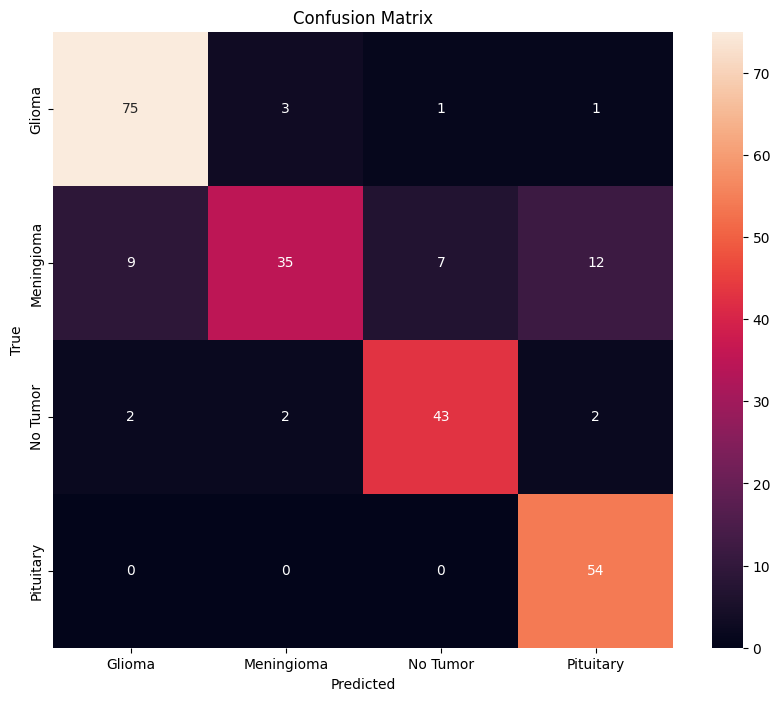

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.87      0.94      0.90        80
  Meningioma       0.88      0.56      0.68        63
    No Tumor       0.84      0.88      0.86        49
   Pituitary       0.78      1.00      0.88        54

    accuracy                           0.84       246
   macro avg       0.84      0.84      0.83       246
weighted avg       0.85      0.84      0.83       246



In [200]:
# Confusion Matrix and Classification Report
test_generator.reset()  # Reset the generator to avoid state issues
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
cr = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", cr)


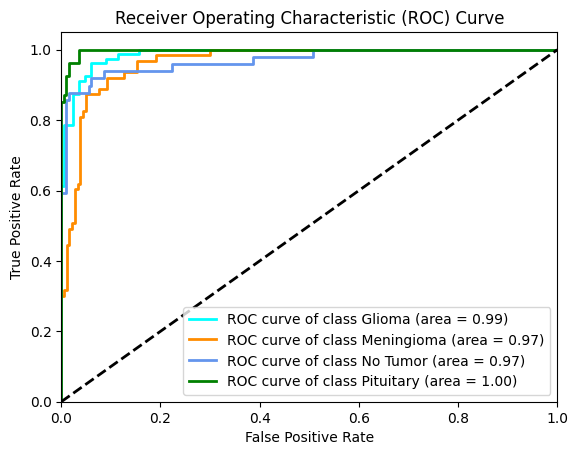

In [201]:
# ROC Curve and AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

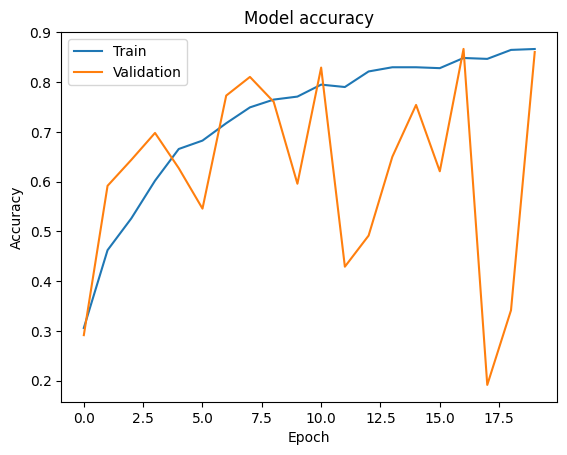

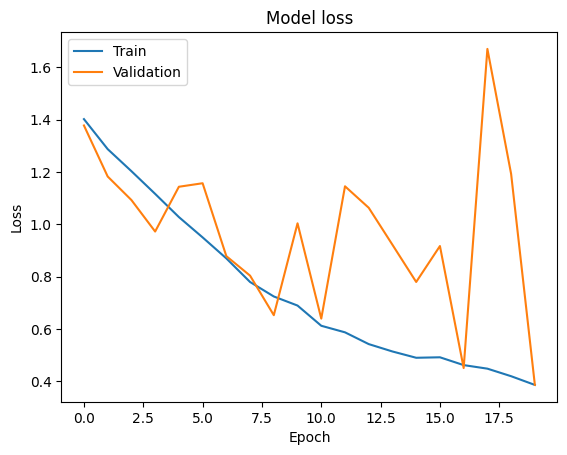

In [202]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [207]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [212]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [213]:


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from itertools import cycle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the EfficientNetV2L model pre-trained on ImageNet
base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [214]:
# Fine-tune the top layers of the model
for layer in base_model.layers:
    layer.trainable = True


In [215]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(base_model.input, outputs)


In [216]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [217]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [218]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
52/52 [==============================] - 578s 9s/step - loss: 1.3354 - accuracy: 0.3632 - val_loss: 1.3550 - val_accuracy: 0.2479 - lr: 1.0000e-05
Epoch 2/20
52/52 [==============================] - 472s 9s/step - loss: 1.1650 - accuracy: 0.5436 - val_loss: 0.8838 - val_accuracy: 0.6917 - lr: 1.0000e-05
Epoch 3/20
52/52 [==============================] - 471s 9s/step - loss: 0.9491 - accuracy: 0.6615 - val_loss: 0.6732 - val_accuracy: 0.7604 - lr: 1.0000e-05
Epoch 4/20
52/52 [==============================] - 468s 9s/step - loss: 0.7501 - accuracy: 0.7523 - val_loss: 0.5033 - val_accuracy: 0.8292 - lr: 1.0000e-05
Epoch 5/20
52/52 [==============================] - 458s 9s/step - loss: 0.6170 - accuracy: 0.7986 - val_loss: 0.4547 - val_accuracy: 0.8646 - lr: 1.0000e-05
Epoch 6/20
52/52 [==============================] - 463s 9s/step - loss: 0.4742 - accuracy: 0.8394 - val_loss: 0.3377 - val_accuracy: 0.8813 - lr: 1.0000e-05
Epoch 7/20
52/52 [==============================] - 

In [219]:
# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so we can print in order
)

Found 246 images belonging to 4 classes.


In [220]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {accuracy}')


7/7 [==============================] - 9s 1s/step - loss: 0.2255 - accuracy: 0.9330
Test accuracy: 0.9330357313156128


8/8 [==============================] - 17s 1s/step


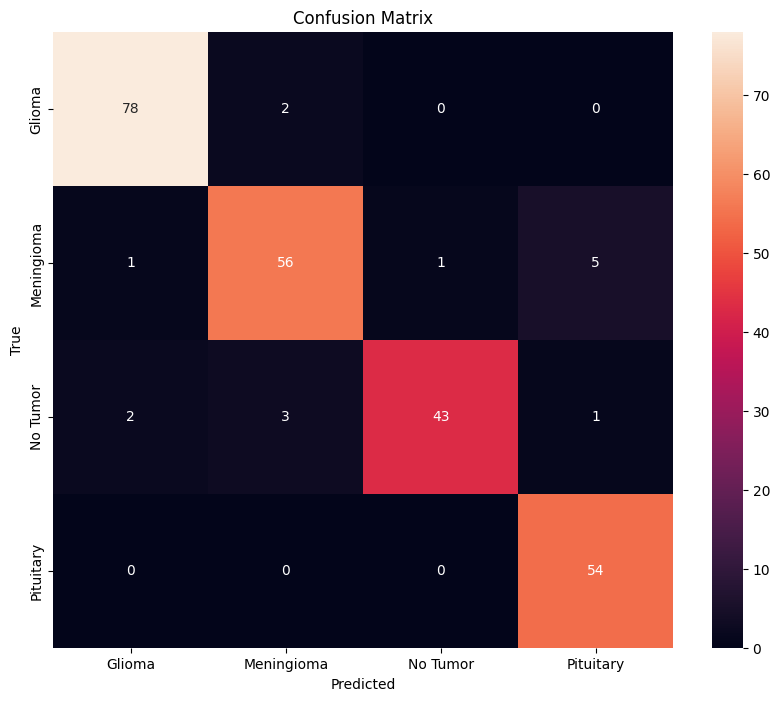

Classification Report:
               precision    recall  f1-score   support

      Glioma       0.96      0.97      0.97        80
  Meningioma       0.92      0.89      0.90        63
    No Tumor       0.98      0.88      0.92        49
   Pituitary       0.90      1.00      0.95        54

    accuracy                           0.94       246
   macro avg       0.94      0.94      0.94       246
weighted avg       0.94      0.94      0.94       246



In [221]:
# Confusion Matrix and Classification Report
test_generator.reset()  # Reset the generator to avoid state issues
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
cr = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", cr)

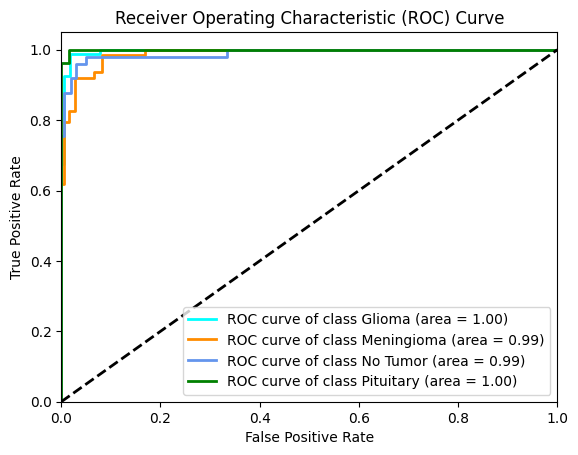

In [223]:
# ROC Curve and AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



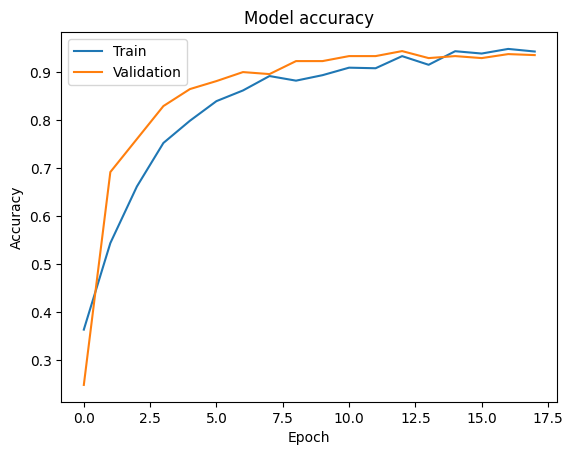

In [224]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

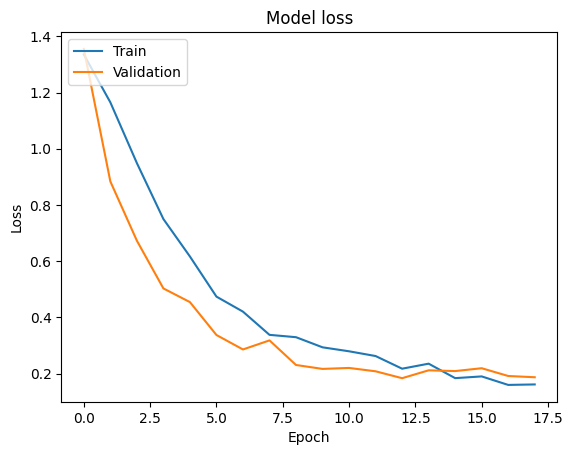

In [225]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model

# Define directories
output_dir = '/content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.tensorflow/train_not_blurred/'
features_output_dir = '/content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.tensorflow/features/'

if not os.path.exists(features_output_dir):
    os.makedirs(features_output_dir)

# Step 1: Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Step 2: Preprocess and extract features
def extract_features(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array)
    return features.flatten()

# Initialize a DataFrame to store features and filenames
features_list = []

# Process each non-problematic image and extract features
for filename in os.listdir(output_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(output_dir, filename)
        features = extract_features(image_path, model)

        features_list.append(pd.Series(features, name=filename))

# Create DataFrame from the list of features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv(os.path.join(features_output_dir, 'features.csv'))

print("Feature extraction completed and saved.")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load features and labels
features_df = pd.read_csv(os.path.join(features_output_dir, 'features.csv'), index_col=0)
labels_df = pd.read_csv('/content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.tensorflow/train/_annotations.csv')

# Merge features with labels
features_df['filename'] = features_df.index
data = pd.merge(features_df, labels_df, left_on='filename', right_on='filename')

# Separate features and labels
X = data.drop(columns=['filename', 'class'])
y = data['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(svm_model.classes_)):
    y_true_binary = (y_test == svm_model.classes_[i])
    y_prob = svm_model.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_true_binary, y_prob)
    auc = roc_auc_score(y_true_binary, y_prob)
    plt.plot(fpr, tpr, label=f'{svm_model.classes_[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
